# Logistic Regression

In this exercise we will implement logisitic regression. We will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

In [1]:
# A bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from csl712.classifiers.fc_net import *
from csl712.data_utils import get_CIFAR10_data
from csl712.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from csl712.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed - mean subtracted) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: foward
Open the file `csl712/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare the outputs. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769847728806635e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [4]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# Sigmoid layer: forward
Implement the forward pass for the Sigmoid activation function in the `sigmoid_forward` function and test your implementation using the following:

In [5]:
# Test the sigmoid_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = sigmoid_forward(x)
correct_out = np.array([[ 0.3775,  0.3991,  0.4211,  0.4434],
                        [ 0.4660,  0.4886,  0.5114,  0.5340],
                        [ 0.5566,  0.5789,  0.6009,  0.6225]])

# Compare your output. The error should be around 5e-4
print('Testing sigmoid_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing sigmoid_forward function:
difference:  5.386305642335815e-05


# Sigmoid layer: backward
Implement the backward pass for the Sigmoid activation function in the `sigmoid_backward` function and test your implementation using the following:

In [14]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: sigmoid_forward(x)[0], x, dout)

_, cache = sigmoid_forward(x)
dx = sigmoid_backward(dout, cache)

# The error should be around 3e-11
print('Testing sigmoid_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing sigmoid_backward function:
dx error:  3.446520386706568e-11


# Loss layer: Softmax
Softmax loss is implemented for you. You should still make sure you understand how it works by looking at the implementations in `csl712/layers.py`.

You can make sure that the implementations are correct by running the following:

In [15]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be less than 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# Logistic Regression

In this you will implement logisitic regression.

Open the file `csl721/classifiers/fc_net.py` and complete the implementation of the `LogisticRegression` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. One more cell can be implemented to test the correctness of model.

# Solver
The logic for training models was split into a separate class. Open the file `csl712/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `LogisticRegression`. First observe relation between batch size and learning rate. Then train for the best model

In [16]:
# Batch Size vs learning rate

##############################################################################
# TODO: Observe the relation between batch size and learning rate (lr).      #
##############################################################################

solver_dct = {}

batch_sizes = [256, 128, 64, 32, 16, 8]
learning_rates = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]


for batch_size in batch_sizes:
    for lr in learning_rates:
        model = LogisticRegression(reg = 0)
        solver = Solver(model, data, update_rule='sgd', optim_config={'learning_rate': lr,}, lr_decay=0.95, 
                        num_epochs = 10, batch_size = batch_size, verbose = False)
        solver.train()
        
        solver_dct[batch_size, lr] = solver #will be used next for plotting
        
        print (str(batch_size) + " batch size and " + str(lr) + " learning rate with 10 epochs done.")
        
num_batches = len(batch_sizes)
num_lr = len(learning_rates)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

256 batch size and 1e-07 learning rate with 10 epochs done.
256 batch size and 1e-06 learning rate with 10 epochs done.
256 batch size and 1e-05 learning rate with 10 epochs done.
256 batch size and 0.0001 learning rate with 10 epochs done.
256 batch size and 0.001 learning rate with 10 epochs done.
256 batch size and 0.01 learning rate with 10 epochs done.
128 batch size and 1e-07 learning rate with 10 epochs done.
128 batch size and 1e-06 learning rate with 10 epochs done.
128 batch size and 1e-05 learning rate with 10 epochs done.
128 batch size and 0.0001 learning rate with 10 epochs done.
128 batch size and 0.001 learning rate with 10 epochs done.
128 batch size and 0.01 learning rate with 10 epochs done.
64 batch size and 1e-07 learning rate with 10 epochs done.
64 batch size and 1e-06 learning rate with 10 epochs done.
64 batch size and 1e-05 learning rate with 10 epochs done.
64 batch size and 0.0001 learning rate with 10 epochs done.
64 batch size and 0.001 learning rate with 

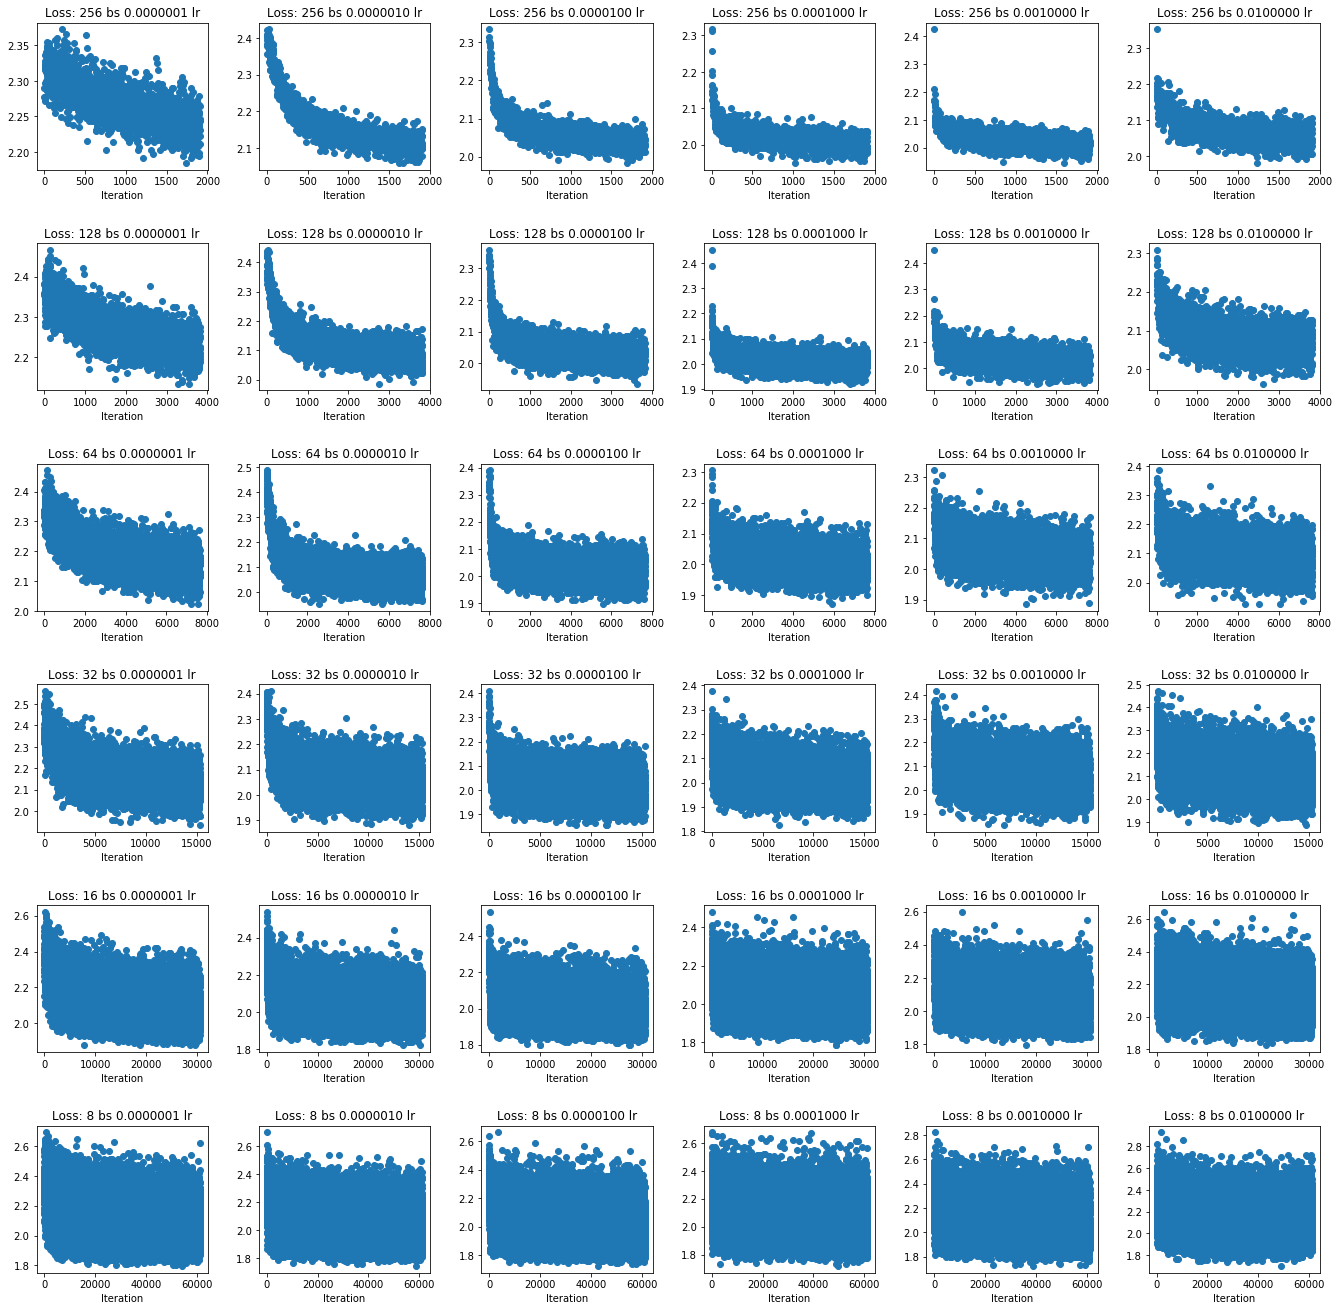

In [17]:
# Run this cell to visualize training loss

for i,batch_size in enumerate(batch_sizes):
    for j,lr in enumerate(learning_rates):
        plt.subplot(num_batches, num_lr, (i*num_lr)+j+1)
        plt.title('Loss: %d bs %.7f lr' %(batch_size,lr))
        plt.plot(solver_dct[batch_size,lr].loss_history, 'o')
        plt.xlabel('Iteration')
        plt.subplots_adjust(wspace = 0.3, hspace=0.5)
plt.gcf().set_size_inches(23, 23)
plt.show()

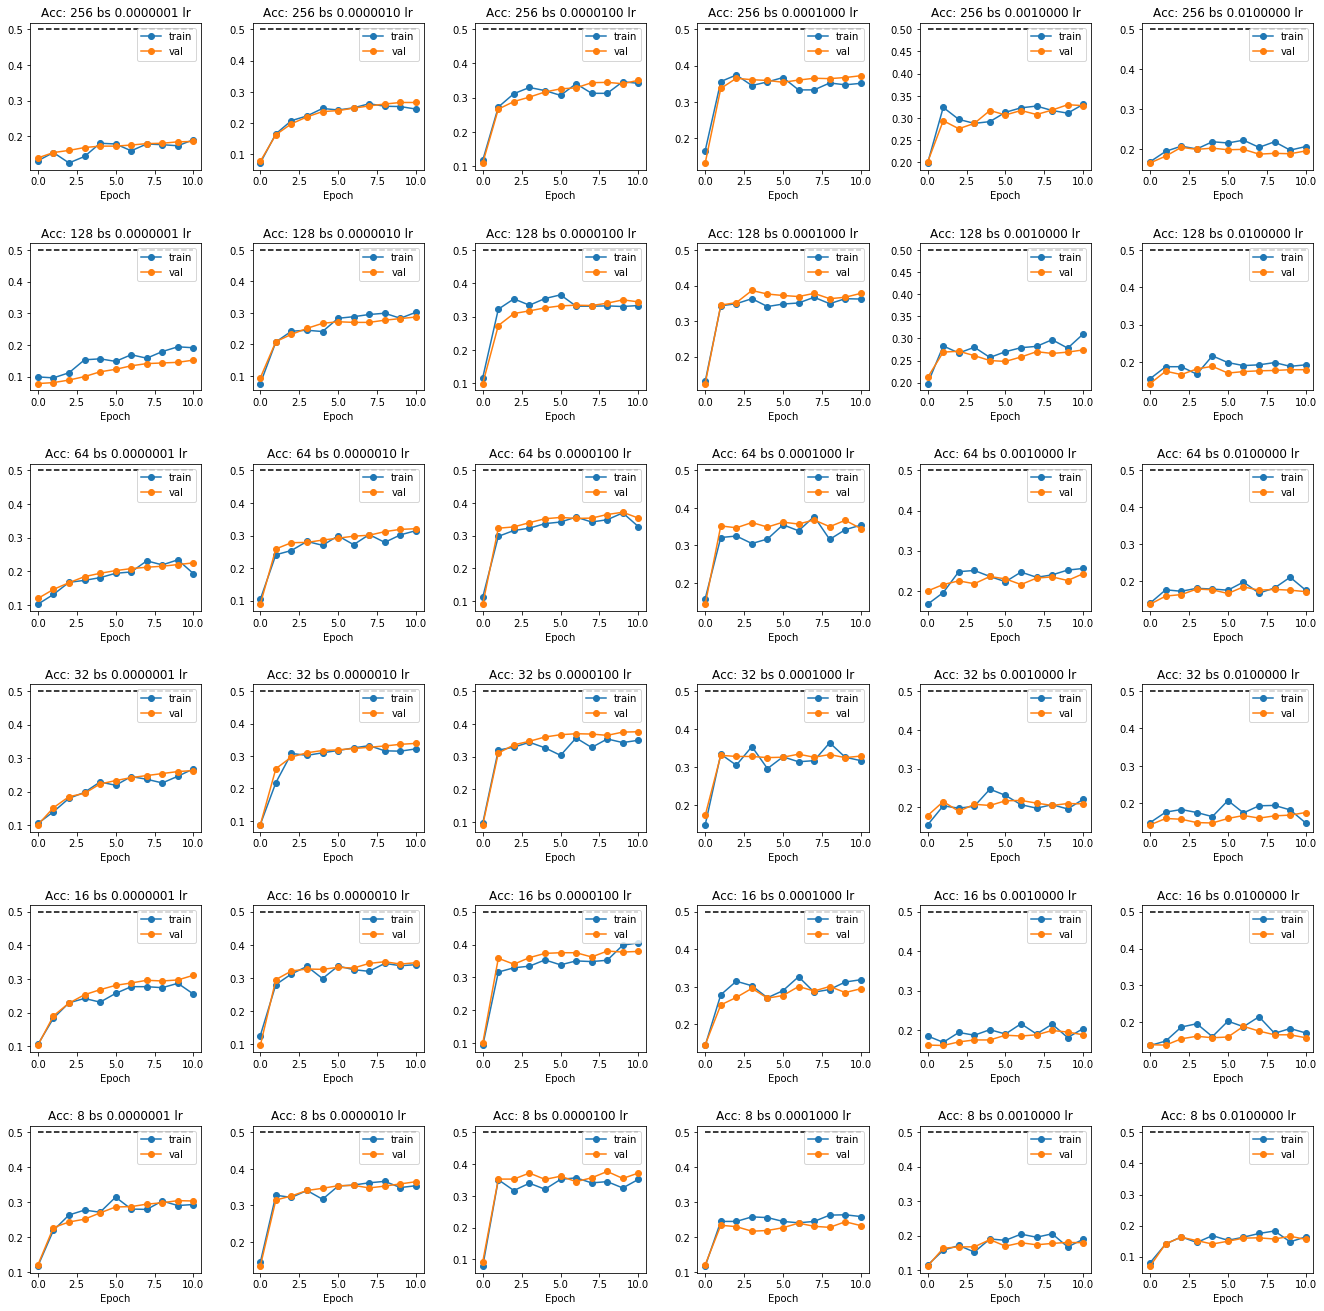

In [18]:
# Run this cell to visualize train / val accuracy

for i,batch_size in enumerate(batch_sizes):
    for j,lr in enumerate(learning_rates):
        plt.subplot(num_batches, num_lr, (i*num_lr)+j+1)
        plt.title('Acc: %d bs %.7f lr' %(batch_size,lr))
        plt.plot(solver_dct[batch_size,lr].train_acc_history, '-o', label='train')
        plt.plot(solver_dct[batch_size,lr].val_acc_history, '-o', label='val')
        plt.plot([0.5] * len(solver.val_acc_history), 'k--')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
        plt.subplots_adjust(wspace = 0.3, hspace=0.5)
plt.gcf().set_size_inches(23, 23)
plt.show()

Seeing both the above plots. Going with more batch size seems to be good from the losses graph and doesn't seem to matter that much from accuracy plots, so going with batch_size same as training data may be good but computation limits available should also be taken into consideration. Here the idea of good is that it's decreasing nice unlike in smaller batch sizes even though loss decrease is more it seems more noisy. Therefore batch_size is set to 64. Now going to learning_rate, for lower values it's learning slow and for higher values it's might be zigzaging and so going to sweetspot in between two, going with 1e-5 which looks good from both plots than the remaining learning rates.

# Best Model

Train the best model you can with this maximizing the `validation` accuracy.

In [19]:
best_model = None
best_val_acc = 0.0

##############################################################################
# TODO: Use a Solver instance to train the best possible model.              #
##############################################################################
regs = [1e-7, 5e-7, 7e-7, 1e-6, 5e-6, 7e-6]

for reg in regs:
    model = LogisticRegression(reg = reg)
    solver = Solver(model, data, update_rule='sgd', optim_config={'learning_rate': 1e-5,}, lr_decay=0.95, 
                        num_epochs = 50, batch_size = 64, verbose = False)
    solver.train()
    
    print ("For " + str(reg) + " regularization validation accuracy is: " + str(solver.best_val_acc))
    
    if (best_val_acc < solver.best_val_acc):
        best_model = model
        best_val_acc = solver.best_val_acc
        
print ("Better Validation accuracy is: " + str(best_val_acc))
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

For 1e-07 regularization validation accuracy is: 0.384
For 5e-07 regularization validation accuracy is: 0.381
For 7e-07 regularization validation accuracy is: 0.385
For 1e-06 regularization validation accuracy is: 0.38
For 5e-06 regularization validation accuracy is: 0.383
For 7e-06 regularization validation accuracy is: 0.387
Better Validation accuracy is: 0.387


# Test you model
Run your best model on the validation and test sets. 

In [21]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.387
Test set accuracy:  0.344


# References

All the code of this is reused and built on from this excellent [course](http://cs231n.stanford.edu/) [assignment](http://cs231n.github.io/assignments2017/assignment2/)